#### imports and functions

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(30)  # For reproducibility


""" homemade StandardScaler ripped of from sklearn """
class CustomStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        """
        Compute the mean and standard deviation of the dataset.
        
        Parameters:
        X (numpy array): The input features to be scaled.

        """
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        
    def transform(self, X):
        """
        Scale the dataset to zero mean and unit variance.
        
        Parameters:
        X (numpy array): The input features to be scaled.
        
        Returns:
        numpy array: The scaled version of the input features.
        """
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        """
        Fit to data, then transform it.
        
        Parameters:
        X (numpy array): The input features to be scaled.
        
        Returns:
        numpy array: The scaled version of the input features.
        """
        self.fit(X)
        return self.transform(X)


# Task 1

In [1]:

# load the data
data = pd.read_csv('../data/SpotifyFeatures.csv')
# print(data.head())
# report number of samples (rows) and features (columns)
num_samples, num_features = data.shape[0], data.shape[1] 

print(f'Number of samples: {num_samples}')
print(f'Number of features: {num_features}')



Number of samples: 232725
Number of features: 18


# Filtering the dataset for Pop and Classical genres

In [2]:
# Using .copy() to avoid modifying the original data and avoid SettingWithCopyWarning
pop_class_df = data[data['genre'].isin(['Pop', 'Classical'])].copy()
# print(pop_class_df.head())

# Create labels: 'Pop' = 1, 'Classical' = 0

In [3]:
# Using .loc to explicitly modify the Dataframe and avoid modifying the original data
pop_class_df.loc[:, 'label'] = pop_class_df['genre'].apply(lambda x: 1 if x == 'Pop' else 0)

# Reporting the number of samples for each class

In [4]:
# .shape[0] returns the number of rows (songs) for each class.
num_pop = pop_class_df[pop_class_df['label'] == 1].shape[0]
num_classical = pop_class_df[pop_class_df['label'] == 0].shape[0]

print(f'Number of Pop songs: {num_pop}')
print(f'Number of Classical songs: {num_classical}')

Number of Pop songs: 9386
Number of Classical songs: 9256


# Extracting the features and labels 

In [6]:
# Extracting only the 'liveness' and 'loudness' features into a numpy array
features = pop_class_df[['liveness', 'loudness']].values
# Extracting the labels into a numpy array (1 for Pop, 0 for Classical)
labels = pop_class_df['label'].values

print(f'Number of features: {features.shape[0]}')
print(f'Number of labels: {labels.shape[0]}')



if features.shape[0] == labels.shape[0]:
    print('Number of features and labels match!')
else:
    print('Number of features and labels do not match!')

print(f"Liveness range: {features[:, 0].min()} to {features[:, 0].max()}")
print(f"Loudness range: {features[:, 1].min()} to {features[:, 1].max()}")

    

Number of features: 18642
Number of labels: 18642
Number of features and labels match!
Liveness range: 0.0157 to 0.987
Loudness range: -47.599 to 0.634


# Training - test split

In [7]:

# Define the train-test split ratio (80% for training, 20% for testing)
train_ratio = 0.8

# Shuffle the data before splitting
np.random.seed(42)  # For reproducibility
indices = np.random.permutation(len(features))  # Generate a random permutation of indices

# Normalize only the 'loudness' feature (I tried this but I did not get any improvement)
# features[:, 1] = (features[:, 1] - features[:, 1].min()) / (features[:, 1].max() - features[:, 1].min())


# Shuffle the features and labels using the shuffled indices
features_shuffled = features[indices]
labels_shuffled = labels[indices]


# Calculate the number of training samples
train_size = int(train_ratio * len(features_shuffled))

# Split the data into training and test sets
X_train = features_shuffled[:train_size]    # First 80% of the shuffled data for training
y_train = labels_shuffled[:train_size]      # First 80% of the shuffled labels for training

X_test = features_shuffled[train_size:]     # Remaining 20% for testing
y_test = labels_shuffled[train_size:]       # Remaining 20% of the shuffled labels for testing

# # Calculate the number of training samples
# train_size = int(train_ratio * len(features))

# # Split the data into training and test sets
# X_train = features[:train_size]    # First 80% of the shuffled data for training
# y_train = labels[:train_size]      # First 80% of the shuffled labels for training

# X_test = features[train_size:]     # Remaining 20% for testing
# y_test = labels[train_size:]       # Remaining 20% of the shuffled labels for testing

# Print the shapes to verify the split
print(f'Training Feature: {X_train.shape[0]}')
print(f'Training Labels: {y_train.shape[0]}')
print(f'Test Features: {X_test.shape[0]}')
print(f'Test Labels: {y_test.shape[0]}')


# Initialize custom scaler
scaler = CustomStandardScaler()

# Fit and transform the dataset
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Output the scaled data
# print(X_train_scaled[:5])
# print(X_train[:5])
# print(X_test_scaled[:5])
# print(X_test[:5])

Training Feature: 14913
Training Labels: 14913
Test Features: 3729
Test Labels: 3729


Here the data is split up into test/train set. The dataset is shuffled before splitting, this randomizes the order of the data, and potentially prevents any biases or patterns that might affect model performance.

# bonus task ( plotting the liveness vs loudness)

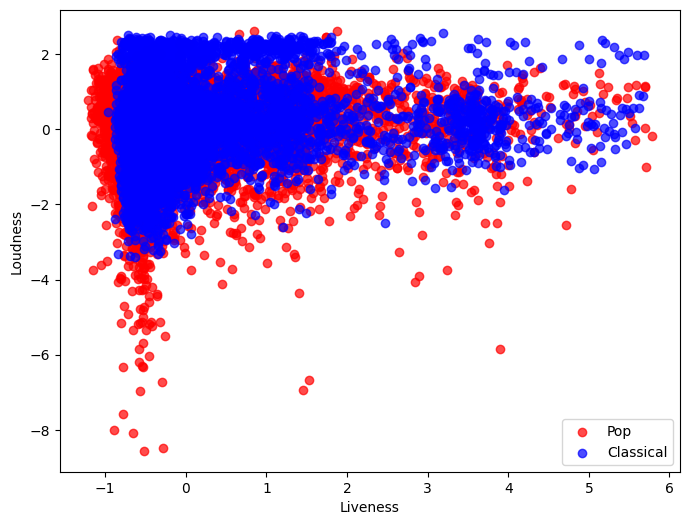

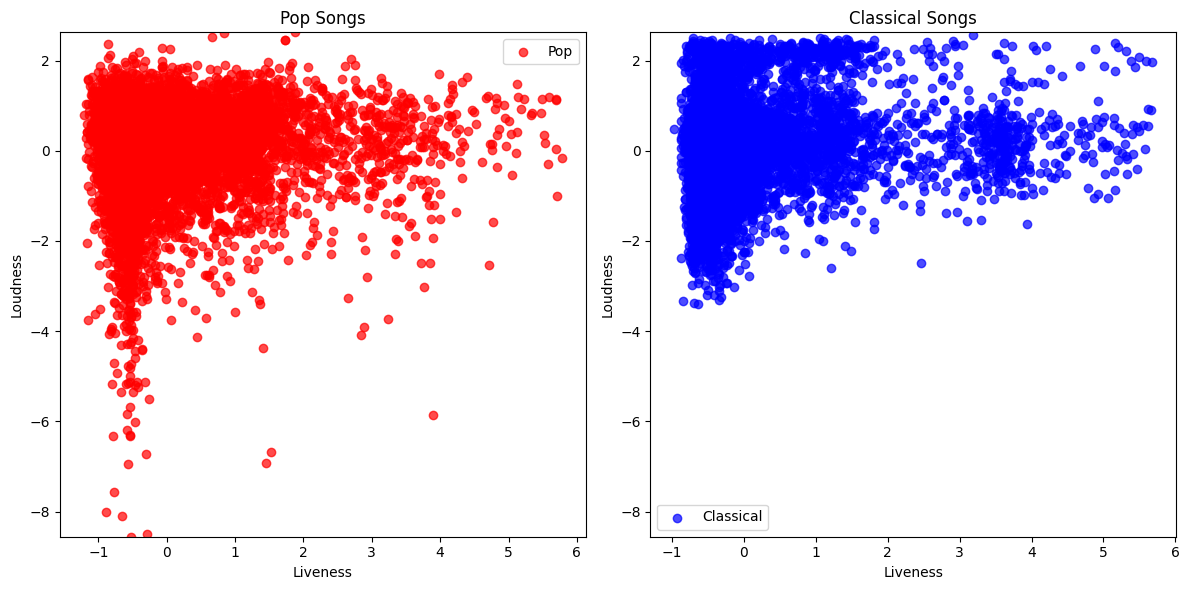

In [26]:
# extract the features for Pop and Classical songs
pop_features = features[labels == 1]
classical_features = features[labels == 0]

# scale the features
pop_features = scaler.fit_transform(pop_features)
classical_features = scaler.fit_transform(classical_features)


# plot the features
plt.figure(figsize=(8, 6))
plt.scatter(pop_features[:, 0], pop_features[:, 1], color='red', label='Pop', alpha=0.7)
plt.scatter(classical_features[:, 0], classical_features[:, 1], color='blue', label='Classical',alpha=0.7)
plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.legend()

# Create subplots with two plots side by side 
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Determine the y-axis limits based on the loudness values (y-values)
y_min = min(pop_features[:, 1].min(), classical_features[:, 1].min())
y_max = max(pop_features[:, 1].max(), classical_features[:, 1].max())

# Plot for Pop songs
axs[0].scatter(pop_features[:, 0], pop_features[:, 1], color='red', label='Pop', alpha=0.7)
axs[0].set_xlabel('Liveness')
axs[0].set_ylabel('Loudness')
axs[0].set_title('Pop Songs')
axs[0].set_ylim([y_min, y_max])  # Set the same y-axis limits for both plots
axs[0].legend()

# Plot for Classical songs
axs[1].scatter(classical_features[:, 0], classical_features[:, 1], color='blue', label='Classical', alpha=0.7)
axs[1].set_xlabel('Liveness')
axs[1].set_ylabel('Loudness')
axs[1].set_title('Classical Songs')
axs[1].set_ylim([y_min, y_max])  # Set the same y-axis limits for both plots
axs[1].legend()

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


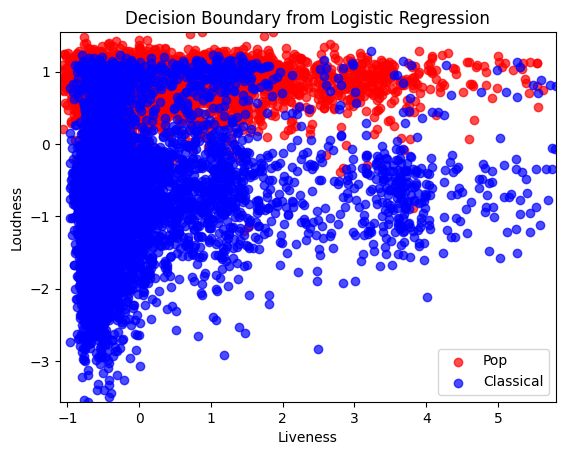

In [42]:
# Scatter plot of the scaled data
plt.scatter(X_train_scaled[y_train == 1][:, 0], X_train_scaled[y_train == 1][:, 1], color='red', label='Pop', alpha=0.7)
plt.scatter(X_train_scaled[y_train == 0][:, 0], X_train_scaled[y_train == 0][:, 1], color='blue', label='Classical', alpha=0.7)

# Plot the decision boundary
# plt.plot(x1_range, x2_range, color='green', label='Decision Boundary')

# Set x and y axis limits to make sure the line and data are visible
plt.xlim(X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max())
plt.ylim(X_train_scaled[:, 1].min(), X_train_scaled[:, 1].max())

# Labels and legend
plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.legend()
plt.title('Decision Boundary from Logistic Regression')
plt.show()

### Plot Analysis and Classification Difficulty

- **Pop (Red) vs Classical (Blue)**:The two classes show some separation in terms of **loudness** (y-axis), with Pop songs generally louder and Classical songs quieter. However, there is some overlap in this feature, particularly in the mid-range loudness values.

- **Liveness**: The **liveness** feature (x-axis) shows significant overlap between the two genres, especially in the lower range (0-2). This overlap makes it harder for a model to use liveness alone to differentiate between Pop and Classical.

- **Clustering**: While Pop songs tend to cluster at higher loudness values, Classical songs are spread across a wider range of both features. The overlap in both loudness and liveness suggests that a simple linear classifier may struggle to perfectly separate these two genres.

- **Classification Difficulty**: Based on this plot, classification is not expected to be straightforward. The overlap in **liveness** between Pop and Classical songs, combined with the moderate overlap in **loudness**, means that a logistic regression model (which relies on a linear decision boundary) might not perform well on this dataset. More complex models or additional features might be needed for better separation.

### Conclusion:
- **Loudness** provides some useful separation between the two genres, but **liveness** alone is not enough to distinguish them. 
- The overlap in both features suggests that **classification will be challenging** using these features alone, and the decision boundary is unlikely to perfectly separate the two genres.


*TEST*

In [9]:
# """ Testing the logistic regression model """

# import numpy as np
# import matplotlib.pyplot as plt

# # Sigmoid function
# def custom_sigmoid(val):
#     return 1 / (1 + np.exp(-val))

# # Stochastic Gradient Descent for Logistic Regression with matrix multiplication
# def custom_logistic_sgd(data_X, data_y, lr, num_epochs):
#     np.random.seed(42)  # For reproducibility
#     # custom_weights = np.zeros(data_X.shape[1])  # Initialize weights to zero
#     custom_weights = np.random.rand(data_X.shape[1])  # Initialize weights randomly
#     custom_errors = []  # To store the training error at each epoch

#     for epoch in range(num_epochs):
#         # Shuffle the data at the start of each epoch
#         data_indices = np.random.permutation(len(data_X))
#         data_X_shuffled = data_X[data_indices]
#         data_y_shuffled = data_y[data_indices]

#         for i in range(data_X.shape[0]):
#             # Compute the linear combination (matrix multiplication of X[i] and weights)
#             z_val = data_X_shuffled[i] @ custom_weights  # Use @ for matrix multiplication
#             pred_h = custom_sigmoid(z_val)  # Apply sigmoid function

#             # Compute the gradient (stochastic for each data point)
#             gradient_val = (pred_h - data_y_shuffled[i]) * data_X_shuffled[i]
#             custom_weights -= lr * gradient_val  # Update weights

#         # Compute the error after each epoch (mean of incorrect predictions)
#         y_train_pred = custom_predict(data_X, custom_weights)
#         training_error = np.mean(y_train_pred != data_y)
#         custom_errors.append(training_error)

#     return custom_weights, custom_errors

# # Prediction function using matrix multiplication
# def custom_predict(input_X, model_weights):
#     z_val = input_X @ model_weights  # Use @ for matrix multiplication
#     y_pred_val = custom_sigmoid(z_val)
#     return (y_pred_val >= 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# # Parameters
# custom_learning_rate = 0.0001
# custom_epochs = 100

# # Train the logistic regression classifier using SGD with shuffling inside
# custom_weights, custom_errors = custom_logistic_sgd(X_train_scaled, y_train, custom_learning_rate, custom_epochs)


# # Plot training error as a function of epochs
# plt.figure(figsize=(6, 3))
# plt.plot(range(custom_epochs), custom_errors)
# plt.xlabel('Epochs')
# plt.ylabel('Training Error')
# plt.title('Training Error vs Epochs (SGD with Matrix Multiplication)')
# plt.show()

# # Calculate training accuracy
# y_train_predictions = custom_predict(X_train_scaled, custom_weights)
# train_acc = np.mean(y_train_predictions == y_train)
# print(f"Training Accuracy: {train_acc * 100:.2f}%")

# # Calculate test accuracy
# y_test_predictions = custom_predict(X_test_scaled, custom_weights)
# test_acc = np.mean(y_test_predictions == y_test)
# print(f"Test Accuracy: {test_acc * 100:.2f}%")


# Task 2 - The Machine Learning part

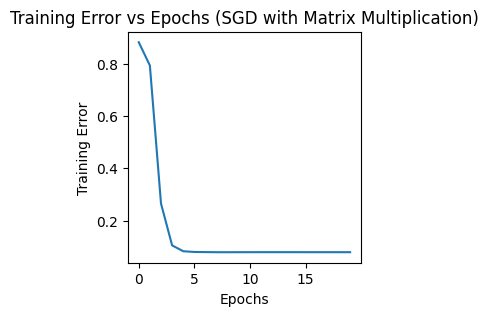

Training Accuracy: 92.11%
Test Accuracy: 91.85%


In [10]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Stochastic Gradient Descent for Logistic Regression with matrix multiplication
def logistic_sgd(X, y, learning_rate, epochs):
    weights = np.random.randn(X.shape[1])  # Initialize weights randomly
    # weights = np.zeros(X.shape[1])  # Initialize weights to zero
    errors = []  # To store the training error at each epoch

    for epoch in range(epochs):
        for i in range(X.shape[0]):
            # Compute the linear combination (matrix multiplication of X[i] and weights)
            z = X[i] @ weights  # Use @ for matrix multiplication
            h = sigmoid(z)  # Apply sigmoid function
            
            # Compute the gradient (stochastic for each data point)
            gradient = (h - y[i]) * X[i]  # No need for dot product here, since it's element-wise
            weights -= learning_rate * gradient  # Update weights
            
        # Compute the error after each epoch (mean of incorrect predictions)
        y_pred = predict(X, weights)
        error = np.mean(y_pred != y)
        errors.append(error)

    return weights, errors

# Prediction function using matrix multiplication
def predict(X, weights):
    z = X @ weights  # Use @ for matrix multiplication
    y_pred = sigmoid(z)
    return (y_pred >= 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Parameters
learning_rate = 0.0001
epochs = 20

 # Shuffle the data at the start of each epoch to avoid biased gradients (due to order)
# np.random.seed(42)  # For reproducibility
indices = np.random.permutation(len(X_train))  # Shuffle indices
X_shuffled = X_train_scaled[indices]  # Apply the shuffled indices to features
y_shuffled = y_train[indices]  # Apply the shuffled indices to labels


# Train the logistic regression classifier using SGD
weights, errors = logistic_sgd(X_shuffled, y_shuffled, learning_rate, epochs)
# weights, errors = logistic_sgd(X_train, y_train, learning_rate, epochs)


# Plot training error as a function of epochs
plt.figure(figsize=(3, 3))
plt.plot(range(epochs), errors)
plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.title('Training Error vs Epochs (SGD with Matrix Multiplication)')
plt.show()

# # Report accuracy on the training set
# y_train_pred = predict(X_train, weights)
# accuracy = np.mean(y_train_pred == y_train)
# print(f"Accuracy on the training set: {accuracy * 100:.2f}%")

# Calculate training accuracy
y_train_pred = predict(X_train_scaled, weights)
train_accuracy = np.mean(y_train_pred == y_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Calculate test accuracy
y_test_pred = predict(X_test_scaled, weights)
test_accuracy = np.mean(y_test_pred == y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


### Logistic Regression using Stochastic Gradient Descent (SGD)

#### Plot:
- The **training error** is plotted as a function of the number of epochs to visualize how the model improves over time. The plot shows how the error decreases as the model learns.

#### Sigmoid Function:
- The sigmoid function is used to map any real-valued number to a probability between 0 and 1.
- It is defined as:
  $
  \text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
  $
  This function helps in binary classification by converting the linear output into probabilities.

#### Stochastic Gradient Descent (SGD):
- In **SGD**, the weights are updated after processing each individual training sample (as opposed to batch gradient descent, where weights are updated after processing the entire dataset).
- For each sample, the gradient of the logistic loss is calculated, and the weights are updated:
  $
  \text{weights} -= \text{learning rate} \times (\hat{y} - y) \times X_i
  $
  where:
  - $ \hat{y} $ is the predicted probability (output from the sigmoid function),
  - $ y $ is the actual label,
  - $ X_i $ is the feature vector for the sample.

#### Shuffling:
- Before starting the training process, the data is **shuffled** to ensure that the samples are presented to the model in a random order.
- Shuffling prevents the model from learning patterns based on the original order of the data, which might introduce bias, especially if the data is sorted by class or any other feature.
- In this implementation, the data is shuffled **once before** training, which provides randomness to the training process without the need to shuffle during every epoch. This is common for **SGD**, as it reduces bias due to sequential data presentation.
- I tried earlier with the having the shuffling inside the SGD function, but this gave me a less smooth curve than if i shuffle it outside. It is probably more accurate, but wanting a smoother curve and a higher accuraccy score made me favor putting it outside the function.
#### Prediction Function:
- The **predict** function calculates the dot product of the features and weights, applies the sigmoid function to convert the result into a probability, and then applies a threshold of 0.5 to classify the sample as either class 0 or class 1.

#### Training Error:
- After each epoch, the model's predictions are compared with the true labels, and the error is calculated as the mean of incorrect predictions.

#### Accuracy:
- After training, the model's accuracy is computed by comparing the predicted labels with the actual labels on the training set:
  $
  \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
  $


# bonus task (Plotting linear separation)

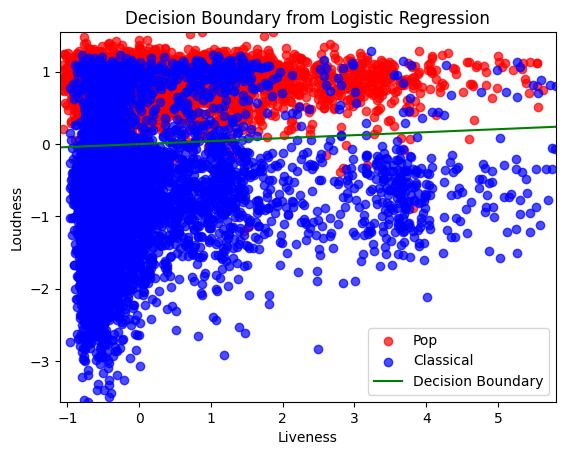

In [12]:
# Plot the data and linear decision boundary
def decision_boundary(x1, weights, intercept=0):
    w1, w2 = weights[0], weights[1]  # Extract weights for liveness (x1) and loudness (x2)
    return -(w1 / w2) * x1 - (intercept / w2)  # Rearrange to get loudness (x2) in terms of liveness (x1)

# Generate liveness values for plotting, make sure it covers the entire x-axis
x1_range = np.linspace(X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max(), 100)

# Calculate corresponding loudness values using the decision boundary equation
x2_range = decision_boundary(x1_range, weights)

# Scatter plot of the original data
plt.scatter(X_train_scaled[y_train == 1][:, 0], X_train_scaled[y_train == 1][:, 1], color='red', label='Pop', alpha=0.7)
plt.scatter(X_train_scaled[y_train == 0][:, 0], X_train_scaled[y_train == 0][:, 1], color='blue', label='Classical', alpha=0.7)

# Plot the decision boundary
plt.plot(x1_range, x2_range, color='green', label='Decision Boundary')

# Set x and y axis limits to make sure the line and data are visible
plt.xlim(X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max())
plt.ylim(X_train_scaled[:, 1].min(), X_train_scaled[:, 1].max())

# Labels and legend
plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.legend()
plt.title('Decision Boundary from Logistic Regression')
plt.show()


### Logistic Regression Line Analysis

1. **Line Placement**:
   - While the green line (decision boundary) isn't perfect, it's probably the best we can get using a straight line to separate **Pop** (red) and **Classical** (blue) songs.
   - The line tries to cut through the middle, but there’s still a lot of overlap between the two groups, especially in terms of **liveness**.

2. **Feature Influence**:
   - **Loudness**: The decision boundary does a decent job of separating louder Pop songs from quieter Classical ones, but it’s not perfect. There’s still some overlap.
   - **Liveness**: The overlap here is making it hard for the model to distinguish between the two genres, which limits the line’s effectiveness.

3. **Model Performance**:
   - Given that this is a straight line, it’s doing what it can with the features provided. However, it's clear that the data is more complex than the line can handle.
   - The model is trying to find a balance between the two features, but with just loudness and liveness, it’s struggling.

4. **Possible Improvements**:
   - **More Features**: Adding additional features like **tempo** or **energy** could improve the model’s performance.
   - **Nonlinear Model**: A more advanced model (like an SVM with a nonlinear kernel or a decision tree) could capture the complexity of the data better.

### Conclusion:
- The line placement isn’t great, but for a straight line, it’s probably the best we can do with just these two features. A more complex model or additional features could help improve the classification.


# Task 3

## 1. Confusion Matrix

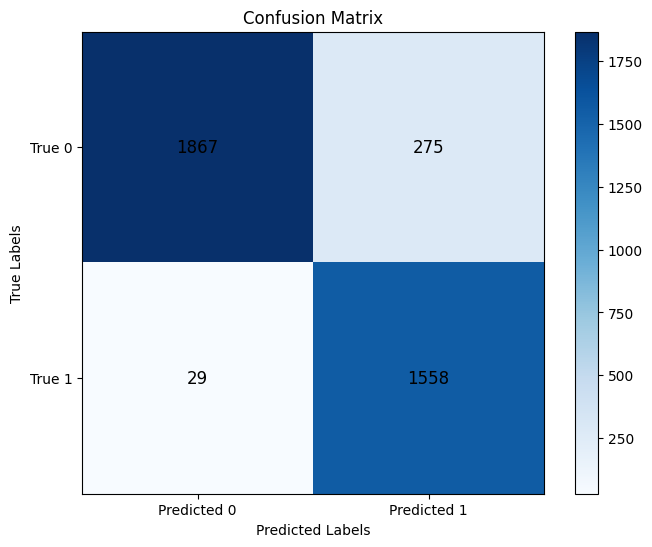

Confusion Matrix:
[[1867  275]
 [  29 1558]]
True Positives: 1867, False Positives: 275
False Negatives: 29, True Negatives: 1558


In [39]:
# Function to calculate the confusion matrix
def confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TP, FP], [FN, TN]])

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Extract the values from the confusion matrix
TP, FP = conf_matrix[0]
FN, TN = conf_matrix[1]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], ['True 0', 'True 1'])

# Annotate the matrix with the values from the confusion matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black', fontsize=12)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# report the number of true positives, false positives, false negatives, and true negatives
print(f"Confusion Matrix:\n{conf_matrix}")

print(f"True Positives: {TP}, False Positives: {FP}")
print(f"False Negatives: {FN}, True Negatives: {TN}")




## Interpretation of confusion matrix:

- **TP (1867)**: Correctly classified Pop songs.
- **FP (275)**: Classical songs misclassified as Pop.
- **FN (29)**: Pop songs misclassified as Classical.
- **TN (1558)**: Correctly classified Classical songs.

#### What does this tell us?

1. **Correct Classifications**:
   - High **TP (1867)** and **TN (1558)** indicate that the model is performing well at distinguishing both genres. It accurately classifies most Pop and Classical songs.

2. **Errors**:
   - **FP (275)**: The model still struggles a bit with misclassifying some Classical songs as Pop, but the number of errors is relatively low.
   - **FN (29)**: Only a small number of Pop songs are being misclassified as Classical, which shows the model is quite good at correctly identifying Pop songs.

3. **Class Bias**:
   - The model has fewer **FN (29)** than **FP (275)**, suggesting it’s more prone to misclassifying Classical songs as Pop rather than the other way around.

4. **Overall Performance**:
   - The model performs very well overall, with a small number of errors. The relatively low **FP** and **FN** counts show that it is quite effective at classifying both genres.

#### Conclusion:
- The model is performing well, but it's slightly more likely to misclassify Classical songs as Pop. 


# Evaluation Measures

Calculating accuracy as `test_y_pred == y_test` gives the overall proportion of correct predictions, but it doesn’t provide insight into the types of errors being made. Accuracy is simply:

$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$

This is equivalent to `np.mean(test_y_pred == y_test)`.

However, by calculating **True Positives**, **True Negatives**, **False Positives**, and **False Negatives** separately, we can better understand the model's performance, especially when there is class imbalance or when the costs of different errors (FP vs FN) are not the same. It helps break down where the model performs well or poorly.



| **Term**        | **Definition**                                      | **Calculation**                      |
|-----------------|-----------------------------------------------------|--------------------------------------|
| **Sensitivity** | Ability to select what needs to be selected          | TP / (TP + FN)                       |
| **Specificity** | Ability to reject what needs to be rejected          | TN / (TN + FP)                       |
| **Precision**   | Proportion of cases found that were relevant         | TP / (TP + FP)                       |
| **Recall**      | Proportion of all relevant cases that were found     | TP / (TP + FN)                       |
| **Accuracy**    | Aggregate measure of classifier performance          | (TP + TN) / (TP + TN + FP + FN)      |


In [35]:

# Sensitivity (Recall)
sensitivity = (TP / (TP + FN)) * 100
print(f"Sensitivity (Recall): {sensitivity:.2f}%")

# Specificity
specificity = (TN / (TN + FP)) * 100
print(f"Specificity: {specificity:.2f}%")

# Precision
precision = (TP / (TP + FP)) * 100
print(f"Precision: {precision:.2f}%")

# Recall (Same as Sensitivity)
recall = (TP / (TP + FN)) * 100
print(f"Recall: {recall:.2f}%")

# Accuracy
accuracy = ((TP + TN) / (TP + TN + FP + FN)) * 100
print(f"Accuracy: {accuracy:.2f}%")

# F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score: {f1_score:.2f}%")

# Test accuracy from predictions
test_accuracy = np.mean(y_test_pred == y_test) * 100
print(f'Accuracy on the test set: {test_accuracy:.2f}%')


Sensitivity (Recall): 98.47%
Specificity: 85.00%
Precision: 87.16%
Recall: 98.47%
Accuracy: 91.85%
F1 Score: 92.47%
Accuracy on the test set: 91.85%


### Model Performance Analysis

- **Sensitivity (Recall)**: The model correctly identified 98.47% of the relevant cases (Pop songs), indicating a strong ability to select what needs to be selected.
- **Specificity**: At 85.00%, the model is less effective at rejecting incorrect classifications (Classical songs), leading to some false positives.
- **Precision**: 87.16% of the cases predicted as Pop were actually Pop, showing good reliability in predictions.
- **Accuracy**: The overall model accuracy is 91.85%, reflecting strong performance across both classes.
- **F1 Score**: The F1 score of 92.47% strikes a balance between precision and recall, indicating the model is robust in both identifying Pop songs and minimizing false positives.

In summary, the model shows strong performance with high recall and accuracy, but there is room for improvement in reducing false positives.
